In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars_examples.dish_bin.grammar_baseline import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *
from spatial_scene_grammars.torch_utils import calculate_mmd

from utils import get_observed_node_sets

import meshcat
import meshcat.geometry as meshcat_geom

Generating from folder  sink/plates_cups_and_bowls/plates
sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring'>
sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado'>
sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise'>
Generating from folder  sink/plates_cups_and_bowls/cups
sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue :  <class 'spatial_scene_grammars_examples.dish_bin.grammar.sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue'>
sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow :  <class 'spatial_

In [2]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7005/static/
Meshcat url:  http://127.0.0.1:7005/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [3]:
# Load in datasets.
observed_node_sets, observed_node_sets_outliers = get_observed_node_sets(reconvert=True)
# One of the 10-element appears to be breaking the multiprocessing stuff,
# so I need to cut them out for now...
observed_node_sets = [o for o in observed_node_sets if len(o) <= 9]
# Go through and convert DishBin to DishBinBaseline
new_observed_node_sets = []
for node_set in observed_node_sets:
    new_nodes = []
    for node in node_set:
        if isinstance(node, DishBin):
            new_node = DishBinBaseline(node.tf)
        else:
            new_node = node
        new_nodes.append(new_node)
    new_observed_node_sets.append(new_nodes)
observed_node_sets = new_observed_node_sets
    
print(len(observed_node_sets), " inlier examples and ", len(observed_node_sets_outliers), " outlier examples")

68  inlier examples and  7  outlier examples


In [4]:
total_of_each_type = {"DishBinBaseline": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBinBaseline': 68, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 34, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 26, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 44, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 29, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 39, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 33, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 27, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 31, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 31}


In [5]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)
pyro.set_rng_seed(42)
grammar = SpatialSceneGrammar(
    root_node_type = DishBinBaseline,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

sampled_tree = grammar.sample_tree(detach=True)
observed_nodes = sampled_tree.get_observed_nodes()

vis["initial_sample"].delete()
draw_scene_tree_contents_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/contents")
draw_scene_tree_structure_meshcat(sampled_tree, zmq_url=vis.window.zmq_url, prefix="initial_sample/structure", node_sphere_size=0.01)

Supertree size 

[2022-02-02 15:54:42.173] [console] [warning] FindResource ignoring DRAKE_RESOURCE_ROOT='/home/gizatt/drake' because it does not contain a 'drake' subdirectory.


 76


In [6]:
counts_by_type = {node_type.__name__: [] for node_type in grammar.all_types}
for nodes in observed_node_sets:
    dummy_tree = SceneTree.make_from_observed_nodes(nodes)
    for node_type in grammar.all_types:
        counts_by_type[node_type.__name__].append(
            len(dummy_tree.find_nodes_by_type(node_type))
        )
print("Max counts by type:", {key: max(value) for key, value in counts_by_type.items()})

Max counts by type: {'TerminalPlate': 0, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 3, 'DishBinBaseline': 1, 'TerminalCup': 0, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 2, 'TerminalBowls': 0, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 3, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 3, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 2, 'TerminalBowl': 0, 'TerminalCups': 0, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 3, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 3, 'TerminalPlates': 0, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 2, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 2}


In [7]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object. Use no pose proposals, as this grammar is pure-dependency.
trees = infer_mle_tree_with_mip_from_proposals(
    grammar, observed_nodes, {}, verbose=1, N_solutions=5, max_recursion_depth=10
)
vis["sampled_scene_parse"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/contents")
for k, tree in enumerate(trees[:3]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sampled_scene_parse/structure/%d" % k, node_sphere_size=0.01)

Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Tue Jan 25 01:18:57 2022

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 297 rows, 114 columns and 649 nonzeros
Model fingerprint: 0xc62b86f7
Variable types: 0 continuous, 114 integer (114 binary)
Coefficient statistics:
  Matrix range     [4e-01, 1e+00]
  Objective range  [7e-01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-01, 1e+00]
Presolve removed 297 rows and 113 columns
Presolve time: 0.00s
Presolved: 0 rows, 1 columns, 0 nonzeros
Variable types: 0 continuous, 1 integer (1 binary)
Found heuristic solution: objective 2.9542961

Root relaxation: objective 2.954296e+00, 0 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0          -    0         2.95430    2.95430  0.00%     -    0s

Optimal solution found at node 0 -

# Approximate EM parameter fitting with IP parser

In [8]:
em = EMWrapper(grammar, observed_node_sets, parsing_strategy="ip_noproposals", do_nlp_refinement=False)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=1, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

Getting MAP parses:   0%|          | 0/68 [00:00<?, ?it/s]

SpatialSceneGrammar(
  (params_by_node_type): ModuleDict(
    (TerminalPlate): ConstrainedParameter()
    (sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl): None
    (DishBinBaseline): ConstrainedParameter()
    (TerminalCup): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise): None
    (TerminalBowls): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow): None
    (sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado): None
    (sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White): None
    (TerminalBowl): ConstrainedParameter()
    (TerminalCups): ConstrainedParameter()
    (sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring): None
    (sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose): None
    (TerminalPlates): ConstrainedParameter()
    (sink:plates_cups_and_bowls:cups:Cole_

In [10]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar_baseline.torch")
with open("fit_em_baseline.pickle", "wb") as fp:
    pickle.dump(em, fp)

# Plotting and inspection of EM fitting process

In [7]:
with open("fit_em_baseline.pickle", "rb") as fp:
    em = pickle.load(fp)
assert len(em.grammar_iters) > 0

Before:  -10700.541290486017 After:  -371.2417606516342


Text(0.5, 1.0, 'Mean and std of scene log p(o)')

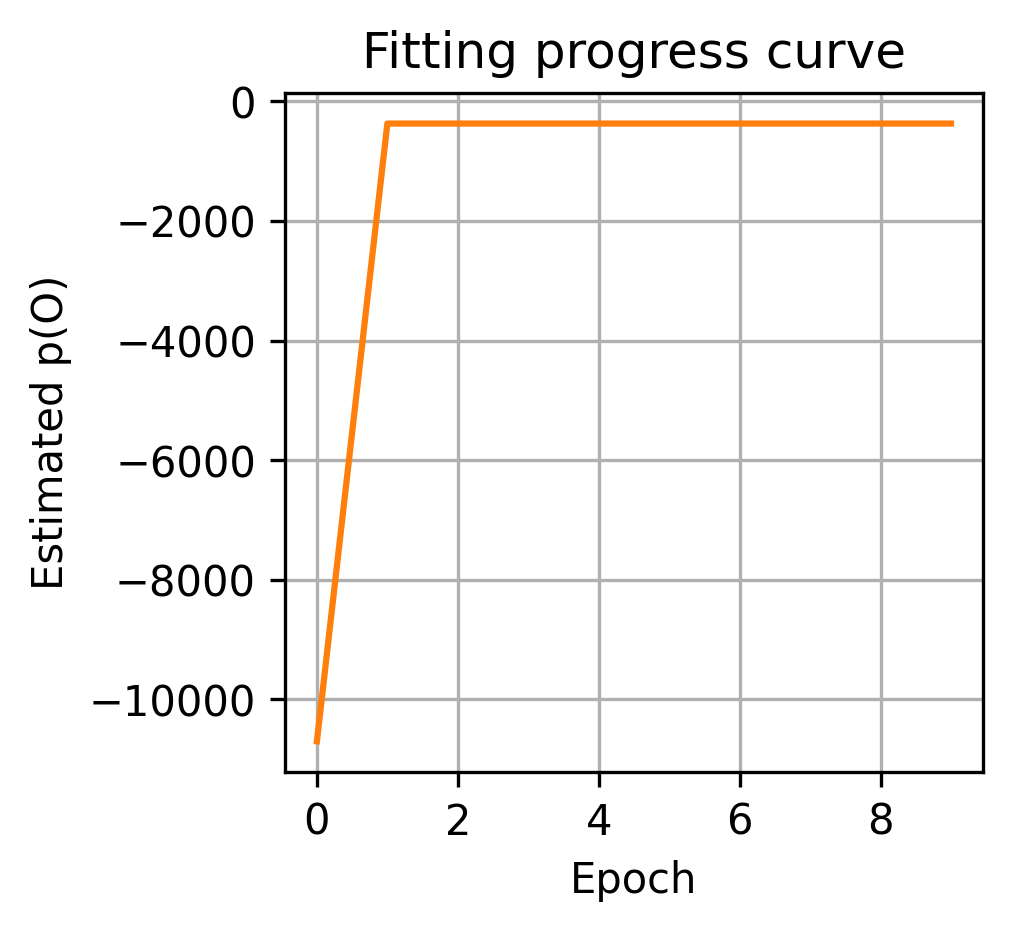

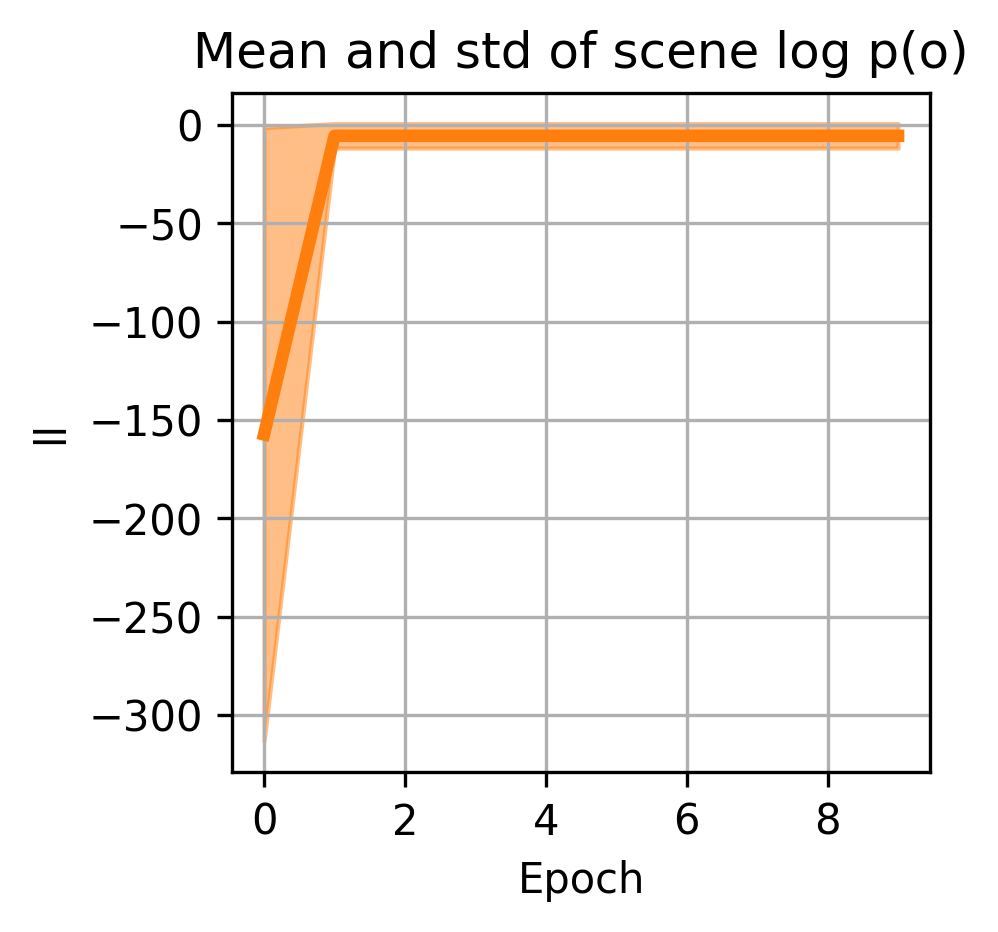

In [12]:
plt.figure(dpi=300).set_size_inches(3, 3)
totals = [np.sum(x) for x in em.log_evidence_iters]
plt.plot(totals, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("Estimated p(O)")
plt.title("Fitting progress curve")
print("Before: ", totals[0], "After: ", totals[-1])

# Slightly different: what's mean + avg p(o) for individual os look like?
plt.figure(dpi=300).set_size_inches(3, 3)
xs = range(len(em.log_evidence_iters))
means = np.array([np.mean(x) for x in em.log_evidence_iters])
stds = np.array([np.std(x) for x in em.log_evidence_iters])
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")
plt.xlabel("Epoch")
plt.grid()
plt.ylabel("ll")
plt.title("Mean and std of scene log p(o)")

In [29]:
# For each step over the fitting process, draw a population of samples from the
# candidate grammar, and collect the population of each terminal object type. Calculate
# MMDs against the corresponding populations of observed object types in the dataset.

# Precompute populations for dataset, and the dictionary we'll use to
# store the distance measurements.
observed_population_by_type = {}
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        key = type(observed_node).__name__
        if key not in observed_population_by_type.keys():
            observed_population_by_type[key] = []
        observed_population_by_type[key].append(observed_node.tf)
for key, value in observed_population_by_type.items():
    observed_population_by_type[key] = torch.stack(value)

mmds_by_type = {key: [] for key in observed_population_by_type.keys()}

# For each EM iteration...
N_samples = 1000
mmd_alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sampled_population_by_type = {key: [] for key in observed_population_by_type.keys()}
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            key = type(observed_node).__name__
            if key not in sampled_population_by_type:
                logging.warning("Sampled object not in observations: %s" % key)
                sampled_population_by_type[key] = []
            sampled_population_by_type[key].append(observed_node.tf)
    for key, value in sampled_population_by_type.items():
        sampled_population_by_type[key] = torch.stack(value)
    # Compute MMDs
    for key in observed_population_by_type.keys():
        observed_pop = observed_population_by_type[key]
        sampled_pop = sampled_population_by_type[key]
        if observed_pop.shape[0] > 0 and sampled_pop.shape[0] > 0:
            mmds_by_type[key].append(
                calculate_mmd(observed_pop, sampled_pop, alphas=mmd_alphas, use_se3_metric=True, beta=0.1)
            )
        else:
            logging.warning("%d observed, %d sampled, can't compare." % (observed_pop.shape[0], sampled_pop.shape[0]))
            mmds_by_type[key].append(np.inf)

  0%|          | 0/11 [00:00<?, ?it/s]

In [8]:
# Alternative MMD calculation: what about MMD of population of all objects? This might be better able to
# capture inter-object covariances.
observed_population_total = []
for observed_nodes in observed_node_sets:
    for observed_node in observed_nodes:
        observed_population_total.append(observed_node.tf)
observed_population_total = torch.stack(observed_population_total)

mmd_total = []

# For each EM iteration...
N_samples = 100
mmd_alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
for k, grammar_state_dict in tqdm(enumerate(em.grammar_iters), total=len(em.grammar_iters)):
    grammar.load_state_dict(grammar_state_dict)
    # Build a population of observed nodes.
    sample_population_total = []
    for k in range(N_samples):
        observed_nodes = grammar.sample_tree(detach=True).get_observed_nodes()
        for observed_node in observed_nodes:
            sample_population_total.append(observed_node.tf)
    sample_population_total = torch.stack(sample_population_total)
    # Compute MMDs
    mmd_total.append(
        calculate_mmd(observed_population_total,
                      sample_population_total,
                      alphas=mmd_alphas,
                      use_se3_metric=True,
                      beta=0.1)
    )

  0%|          | 0/11 [00:00<?, ?it/s]

In [11]:
with open("baseline_em_mmds_precomputed.pickle", "wb") as f:
    pickle.dump(mmds_by_type, f)
with open("baseline_em_mmds_total_precomputed.pickle", "wb") as f:
    pickle.dump(mmd_total, f)

Initial: 0.140962 +/- 0.046104
Final: 0.021332 +/- 0.026113


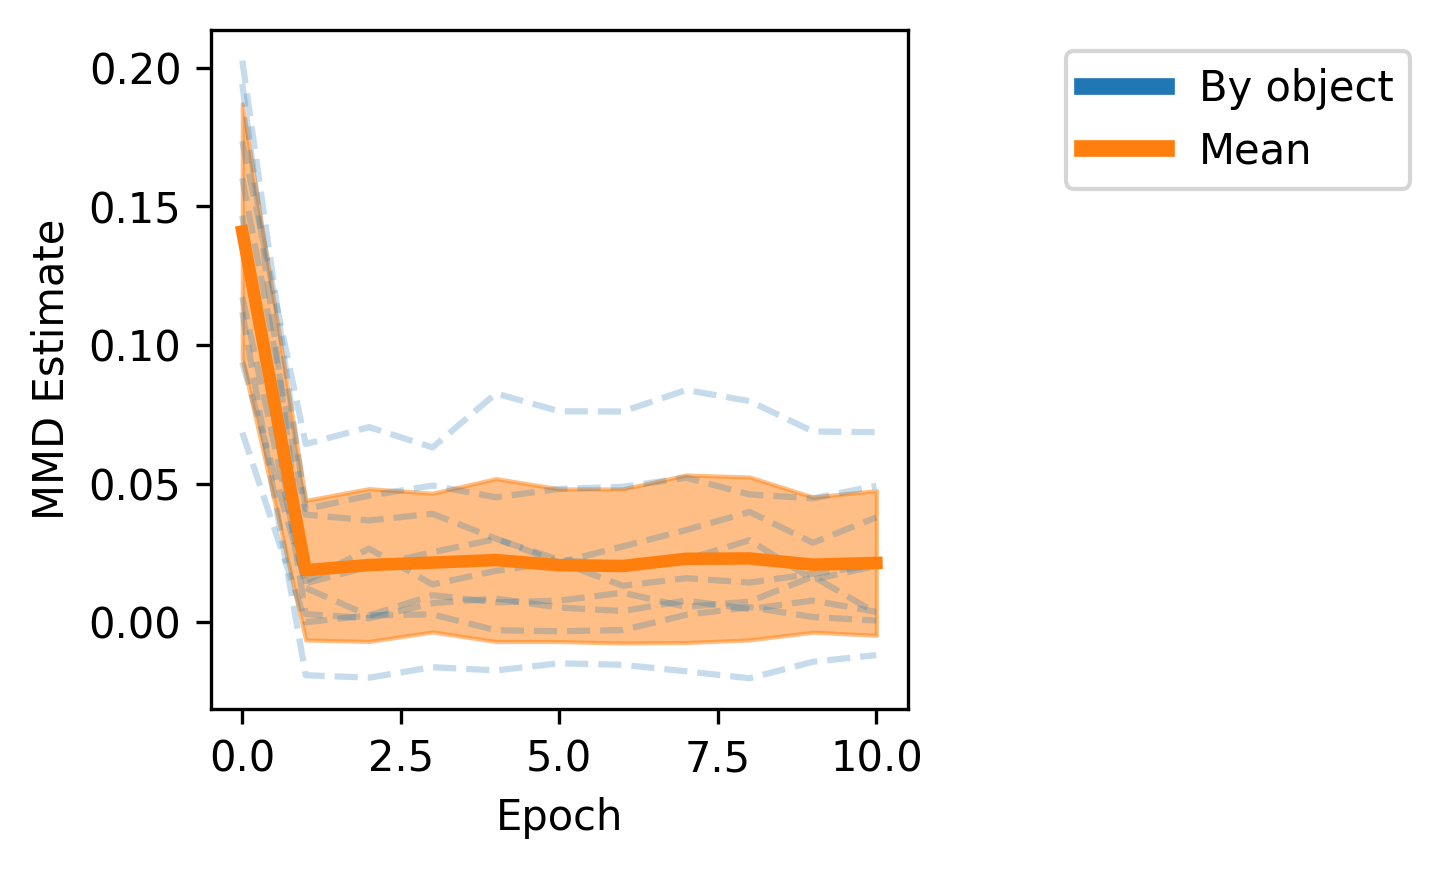

In [31]:
# Plot all of those over time.
plt.figure(dpi=300).set_size_inches(3, 3)



stacked_values = []
for key, value in mmds_by_type.items():
    if key == "DishBinBaseline":
        continue
    plt.plot(value, alpha=0.25, linestyle="--", c="tab:blue")
    stacked_values.append(torch.tensor(value))
stacked_values = torch.stack(stacked_values)
xs = range(stacked_values.shape[1])
means = torch.mean(stacked_values, dim=0)
stds = torch.std(stacked_values, dim=0)
plt.plot(xs, means, linewidth=3, color="tab:orange")
plt.fill_between(xs, means-stds, means+stds, alpha=0.5, color="tab:orange")

plt.xlabel("Epoch")
plt.ylabel("MMD Estimate")
# Custom legend
from matplotlib.lines import Line2D
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
custom_lines = [Line2D([0], [0], color="tab:blue", lw=4, label="By object"),
                Line2D([0], [0], color="tab:orange", lw=4, label="Mean")]
plt.gca().legend(handles=custom_lines, bbox_to_anchor=[1.75, 1])

initial_mmds = stacked_values[:, 0]
last_mmds = stacked_values[:, -1]
print("Initial: %f +/- %f" % (torch.mean(initial_mmds), torch.std(initial_mmds)))
print("Final: %f +/- %f" % (torch.mean(last_mmds), torch.std(last_mmds)))
